In [7]:
%matplotlib widget
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))
from pruning_sb3.pruning_gym.pruning_env import PruningEnv
from pruning_sb3.pruning_gym.models import *
import numpy as np
import cv2
import random
import argparse
from pruning_sb3.args.args import args
from pruning_sb3.pruning_gym.helpers import linear_schedule, exp_schedule, optical_flow_create_shared_vars, \
    set_args, organize_args, add_arg_to_env
import multiprocessing as mp
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [8]:
# Create the ArgumentParser object
parser = argparse.ArgumentParser()
set_args(args, parser)
args, unknown = parser.parse_known_args()
parsed_args = vars(args)
print(args)
parsed_args_dict = organize_args(parsed_args)


Namespace(args_callback_eval_freq=4000, args_callback_n_eval_episodes=40, args_env_movement_reward_scale=5, args_env_distance_reward_scale=0, args_env_condition_reward_scale=0, args_env_terminate_reward_scale=0.4, args_env_collision_reward_scale=-0.005, args_env_slack_reward_scale=-0.01, args_env_pointing_orientation_reward_scale=2, args_env_perpendicular_orientation_reward_scale=3, args_env_max_steps=100, args_env_use_ik=True, args_env_action_scale=0.1, args_env_action_dim=6, args_env_randomize_ur5_pose=False, args_env_randomize_tree_pose=False, args_env_curriculum_distances=(0.95,), args_env_curriculum_level_steps=(), args_train_name='trainenv', args_train_tree_urdf_path='./meshes_and_urdf/urdf/trees/envy/train', args_train_tree_obj_path='./meshes_and_urdf/meshes/trees/envy/train', args_train_tree_labelled_path='./meshes_and_urdf/meshes/trees/envy/train_labelled', args_train_renders=False, args_train_tree_count=100, args_test_tree_urdf_path='./meshes_and_urdf/urdf/trees/envy/test', a

In [61]:
import math

def roundup(x):
    return math.ceil(x / 10.0) * 10

def rounddown(x):
    return math.floor(x / 10.0) * 10

def create_bins(num_latitude_bins, num_longitude_bins):
    """
    Create bins separated by 10 degrees on a unit sphere.

    Parameters:
        num_latitude_bins (int): Number of bins along the latitude direction.
        num_longitude_bins (int): Number of bins along the longitude direction.

    Returns:
        list of tuples: List of tuples where each tuple represents a bin defined by
                        (latitude_min, latitude_max, longitude_min, longitude_max).
    """
    bin_size = np.deg2rad(10)  # Convert degrees to radians
    offset = np.deg2rad(1)
    bins = {}
    for i in range(num_latitude_bins):
        lat_min = np.rad2deg(-np.pi / 2 + i * bin_size)
        lat_max = np.rad2deg(-np.pi / 2 + (i + 1) * bin_size)
        for j in range(num_longitude_bins):
            lon_min = np.rad2deg(-np.pi + j * bin_size)
            lon_max = np.rad2deg(-np.pi + (j + 1) * bin_size)
            bins[(round((lat_min + lat_max)/2), round((lon_min+lon_max)/2))] = []

    return bins


def angle_between_vectors(v1, v2):
    """
    Calculate the angle in radians between two vectors.

    Parameters:
        v1 (numpy.ndarray): First vector.
        v2 (numpy.ndarray): Second vector.

    Returns:
        float: Angle in radians between the two vectors.
    """
    return np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))


def populate_bins(direction_vectors, bins):
    """
    Populate the bins based on a list of direction vectors.

    Parameters:
        direction_vectors (list of numpy.ndarray): List of direction vectors.
        bins (list of tuples): List of bins where each tuple represents a bin defined by
                               (latitude_min, latitude_max, longitude_min, longitude_max).

    Returns:
        list of lists: List of lists where each sublist represents the indices of direction vectors
                       assigned to the corresponding bin.
    """
    for i, direction_vector in enumerate(direction_vectors):
      
        lat_angle = np.rad2deg(np.arcsin(direction_vector[2]))
        lon_angle = np.rad2deg(np.arctan2(direction_vector[1], direction_vector[0]))
        lat_angle_min = rounddown(lat_angle)
        lat_angle_max = roundup(lat_angle)
        lon_angle_min = rounddown(lon_angle)
        lon_angle_max = roundup(lon_angle)
        bin_key = ((lat_angle_min + lat_angle_max) / 2, (lon_angle_min + lon_angle_max) / 2)
        bins[bin_key].append(i)
        
        
      
        # Find the closest bin based on latitude and longitude angles
        # 
        # min_dist = float('inf')
        # closest_bin_idx = None
        # for j, bin_ in enumerate(bins):
        #     lat_min, lat_max, lon_min, lon_max = bin_
        #     if lat_min <= lat_angle <= lat_max and lon_min <= lon_angle <= lon_max:
        #         dist = angle_between_vectors(direction_vector,
        #                                      (np.sin((lat_min + lat_max) / 2), 0, np.cos((lat_min + lat_max) / 2)))
        #         if dist < min_dist:
        #             min_dist = dist
        #             closest_bin_idx = j
        # 
        # # Assign the direction vector to the closest bin
        # bin_assignments[closest_bin_idx].append(i)

    return bins

def visualize_sphere(bins):
    """
    Visualize the unit sphere with bin color representing the frequency of direction vectors.
    
    Parameters:
        bins (list of tuples): List of bins where each tuple represents a bin defined by
                               (latitude_min, latitude_max, longitude_min, longitude_max).
        bin_assignments (list of lists): List of lists where each sublist represents the indices of direction vectors
                                          assigned to the corresponding bin.
        direction_vectors (list of numpy.ndarray): List of direction vectors.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Compute colors
    frequencies = [np.log(len(bin_assignment)+1) for bin_assignment in bins.values()]
    norm = plt.Normalize(vmin=min(frequencies), vmax=max(frequencies))
    cmap = plt.cm.viridis
    scalar_map = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    for i, bin_ in enumerate(bins.keys()):
        lat_center, lon_center = bin_
        lat_min = np.deg2rad(lat_center - 5)
        lat_max = np.deg2rad(lat_center + 5)
        lon_min = np.deg2rad(lon_center - 5)
        lon_max = np.deg2rad(lon_center + 5)
        color = scalar_map.to_rgba(frequencies[i])
        
        # Draw rectangle on the sphere
        u = np.linspace(lon_min, lon_max, 10)
        v = np.linspace(lat_min, lat_max, 10)
        x = np.outer(np.cos(u), np.cos(v))
        y = np.outer(np.sin(u), np.cos(v))
        z = np.outer(np.ones(np.size(u)), np.sin(v))
        ax.plot_surface(x, y, z, color=color, alpha=1)
    
    # Plot direction vectors
    # direction_vectors = np.array(direction_vectors)
    # ax.quiver(0, 0, 0, direction_vectors[:, 0], direction_vectors[:, 1], direction_vectors[:, 2], color='red')
    
    ax.set_xlabel('X - Branch direction')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z - Up')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    cax = fig.add_axes([0.85, 0.1, 0.03, 0.8])
    fig.colorbar(scalar_map, cax=cax, orientation='vertical')
    scalar_map.set_array(frequencies)
    plt.show()
    
    
def visualize_2d(bins):
    # Extract latitude and longitude ranges from each bin
   
    lat_centers, lon_centers = zip(*bins.keys())
    
    # Flatten bin assignments to get frequencies
    frequencies = [np.log(len(bin_assignment)+1) for bin_assignment in bins.values()]
    
    # Convert to numpy arrays for hist2d
    lat_centers = np.array(lat_centers)
    lon_centers = np.array(lon_centers)
    frequencies = np.array(frequencies)
    
    # Create 2D histogram
    figure = plt.figure()
    plt.hist2d(lat_centers, lon_centers, weights=frequencies, bins=[num_latitude_bins, num_longitude_bins], norm=LogNorm())
    plt.colorbar(label='Frequency')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Frequency of orientation in bin')
    plt.show()

In [16]:

args_test = dict(parsed_args_dict['args_env'], **parsed_args_dict['args_train'])
args_test['tree_obj_path'] = '../meshes_and_urdf/meshes/trees/envy/train'
args_test['tree_urdf_path']='../meshes_and_urdf/urdf/trees/envy/train'
args_test['tree_labelled_path'] = '../meshes_and_urdf/meshes/trees/envy/train_labelled'
args_test['tree_count'] = 150
env = PruningEnv(**args_test, make_trees=True)
#get all trees and points
point_list = []
for i in env.trees:
    point_list.extend(i.curriculum_points[0])

orientations = [np.array(i[1][1])/np.linalg.norm(np.array(i[1][1])) for i in point_list]
# orientations = np.array(orientations) / np.linalg.norm(orientations, axis=1)[:, np.newaxis]



../meshes_and_urdf/urdf/trees/envy/train\tree_1.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_1.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_1.obj


Unimplemented OBJ format statement 's' on line 's 1'


KeyboardInterrupt: 

In [62]:
import os, glob, pickle
import numpy as np
reachable_points = []
pkl_path = '../pkl/envy'
glob_path = os.path.join(pkl_path, '*.pkl')
for pkl_path in glob.glob(glob_path):
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
        reachable_points.extend(data[2])
reachable_points = [np.array(i[1])/(np.linalg.norm(np.array(i[1]))+1e-5) for i in reachable_points]

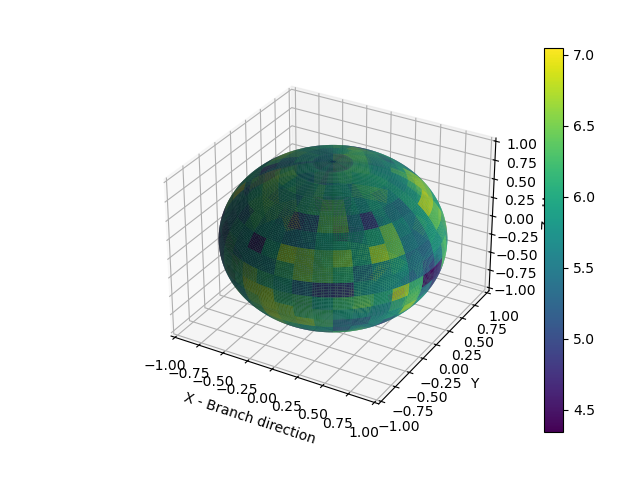

In [63]:

num_latitude_bins = 18  # 90 degrees / 10 degrees per bin = 9 bins
num_longitude_bins = 36  # 360 degrees / 10 degrees per bin = 36 bins
bins = create_bins(num_latitude_bins, num_longitude_bins)
bin_assignments_orientation = populate_bins(reachable_points, bins)
visualize_sphere(bins)


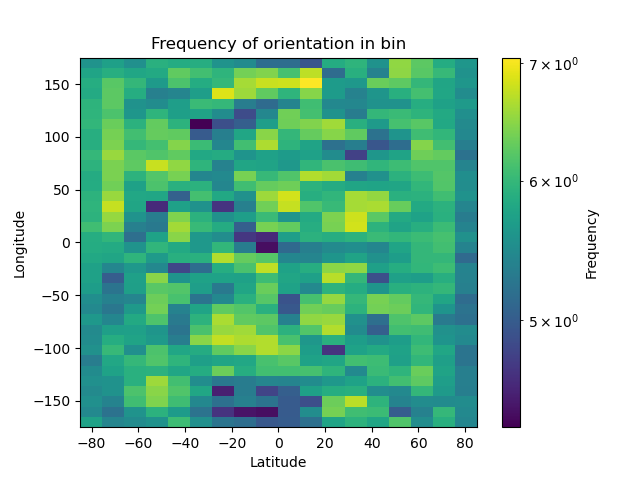

In [64]:
visualize_2d(bins)

In [60]:
num_latitude_bins = 18  # 90 degrees / 10 degrees per bin = 9 bins
num_longitude_bins = 36  # 360 degrees / 10 degrees per bin = 36 bins
bins = create_bins(num_latitude_bins, num_longitude_bins)

bin_assignments_reachable = populate_bins(reachable_points, bins)
visualize_sphere(bins)


TypeError: visualize_sphere() takes 1 positional argument but 2 were given

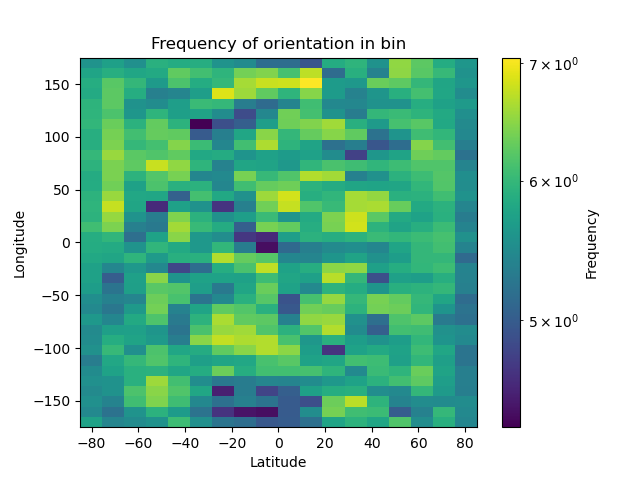

In [54]:
visualize_2d(bins)

In [20]:
frequencies = [len(bin_assignment) for bin_assignment in bin_assignments_reachable]
print(min(frequencies), max(frequencies))

269 3763


In [27]:
frequencies = [len(bin_assignment) for bin_assignment in bin_assignments_orientation]
print(min(frequencies), max(frequencies))

0 446


In [1]:
#I want to bin euclidean space with resolution of 5cm. The euclidean space is a semi-sphere with radius 1m centered at the origin.
# The radius of the sphere is 0.95m, and the semisphere is 45 degrees in the z direction.
# The bins are defined by the center of the bin. Can you help me with this?



In [30]:

# Define the radius and resolution
radius = 0.95  # in meters
resolution = 0.05  # in meters

# Calculate the number of bins in each direction
num_bins = int(radius / resolution)*2

# Create a 3D array to represent the bins
bins = np.zeros((num_bins, num_bins, num_bins))

# Calculate the centers of the bins
centers = np.zeros((num_bins, num_bins, num_bins, 3))
for i in range(-num_bins//2, num_bins//2):
    for j in range(-num_bins//2, num_bins//2):
        for k in range(-num_bins//2, num_bins//2):
            # Calculate the center of the bin
            centers[i, j, k] = [(i + 0.5) * resolution, (j + 0.5) * resolution, (k + 0.5) * resolution]

# Filter out the bins that are outside the semi-sphere or below the 45-degree line in the z direction
valid_centers = []
for i in range(-num_bins//2, num_bins//2):
    for j in range(-num_bins//2, num_bins//2):
        for k in range(-num_bins//2, num_bins//2):
            x, y, z = centers[i, j, k]
            if x**2 + y**2 + z**2 <= radius**2 and y < -0.7:#and z <= np.tan(np.radians(45)) * np.sqrt(x**2 + y**2):
                valid_centers.append((x, y, z))

valid_centers = np.array(valid_centers)
print(valid_centers)

[[-0.575 -0.725 -0.175]
 [-0.575 -0.725 -0.125]
 [-0.575 -0.725 -0.075]
 ...
 [ 0.575 -0.725  0.075]
 [ 0.575 -0.725  0.125]
 [ 0.575 -0.725  0.175]]


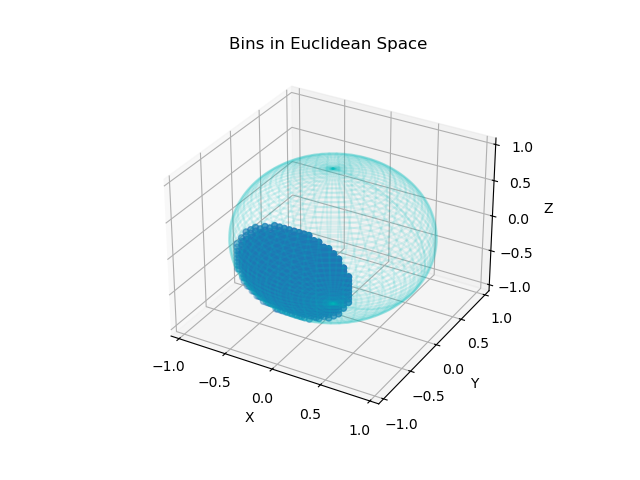

In [29]:

fig = plt.figure()

# Create a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the centers of the valid bins
ax.scatter(valid_centers[:, 0], valid_centers[:, 1], valid_centers[:, 2])

# Create a wireframe sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = radius * np.outer(np.cos(u), np.sin(v))
y = radius * np.outer(np.sin(u), np.sin(v))
z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='c', alpha=0.1)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Bins in Euclidean Space')

# Show the plot
plt.show()